# Radial Velocity and RV Uncertainty Data plots for '55 Cnc'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Use numpy to unpack and return data from text file to program
**USE THIS FUNCTION TO ACCESS DATA**

In [2]:
def read_data_from_txt(text_file):
    data_unpack = np.loadtxt(text_file,unpack=True,usecols=(0,1,2),skiprows=22)
    return data_unpack

Create labeled arrays for each set of data and print

In [3]:
"""Also available to access data if easier"""
global_data_unpack = np.loadtxt('exoplanetinfo.txt',unpack=True,usecols=(0,1,2),skiprows=22)
#print(global_data_unpack)

In [4]:
def print_each_array(text_file):
    data_arrays = read_data_from_txt(text_file)
    hjd = data_arrays[0]
    rv = data_arrays[1]
    rv_uncertainty = data_arrays[2]
    
    print(f"HJD Array (Days): {hjd}")
    print(f"Radial Velocity (m/s): {rv}")
    print(f"Radial Velocity Uncertainty (m/s): {rv_uncertainty}")

Create two plots of the data

In [5]:
def plot_data(text_file):
    # --Read data from the text file--
    data_arrays = read_data_from_txt(text_file)
    hjd = data_arrays[0]
    rv = data_arrays[1]
    rv_uncertainty = data_arrays[2]
    
    # --Initialize figure with two subplots--
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12)) #sharey=True
    
    # --Plot Radial Velocity--
    
    ax1.set_ylabel('Radial Velocity (m/s)')
    ax1.set_xlabel('HJD (Days)')
    ax1.set_title("'55 Cnc' Radial Velocity over HJD")
    ax1.set_ylim(-150, 150)
    ax1.set_yticks(np.arange(-150, 151, 50))
    ax1.grid(True)
    ax1.errorbar(
    hjd, rv, yerr=rv_uncertainty,
    fmt='o', color='green', label='Radial Velocity',
    capsize=5, markersize=3  # adds horizontal lines at top/bottom of error bars
    )
    ax1.legend()
    
    # --Plot RV Uncertainty--
    ax2.scatter(hjd, rv_uncertainty, color='red', marker='o', label='RV Uncertainty')
    ax2.set_ylabel('Radial Velocity Uncertainty (m/s)')
    ax2.set_xlabel('HJD (Days)')
    ax2.legend()
    ax2.set_title("'55 Cnc' Radial Velocity Uncertainty over HJD")
    ax2.set_ylim(0, 5)
    ax2.set_yticks(np.arange(0, 6, 1))
    
    ax2.grid(True)
    
    
    
    # --Adjust layout--
    plt.tight_layout()
    plt.show()

    # --Save as PDF--
    plt.savefig('55_cnc_data_plots.pdf', format='pdf')

In [6]:
#print(read_data_from_txt('exoplanetinfo.txt'))

In [7]:
print_each_array('exoplanetinfo.txt')

HJD Array (Days): [2449676.0632  2449767.77441 2449768.83203 2449793.79785 2450056.98828
 2450087.88184 2450088.91894 2450089.00586 2450089.77637 2450089.98633
 2450090.74512 2450090.89258 2450091.84863 2450091.96973 2450120.87243
 2450121.88866 2450124.85765 2450125.77783 2450126.83752 2450127.85104
 2450128.86732 2450144.71034 2450144.85357 2450145.625   2450145.76465
 2450148.88742 2450150.74885 2450152.66281 2450168.74902 2450171.73959
 2450172.68686 2450173.72485 2450179.73422 2450180.68848 2450181.63379
 2450186.73954 2450187.68636 2450199.68319 2450200.70104 2450201.68663
 2450202.68868 2450203.68772 2450214.68668 2450215.67357 2450233.69028
 2450422.00586 2450437.92852 2450441.9541  2450502.78136 2450503.76303
 2450504.77366 2450536.77162 2450537.7645  2450550.72661 2450563.71983
 2450614.69333 2450793.90234 2450794.96191 2450831.93164 2451153.0332
 2451155.01856 2451206.87793 2451212.92549 2451213.88293 2451242.74023
 2451298.72157 2451305.70801 2451469.05273 2451532.99609 245

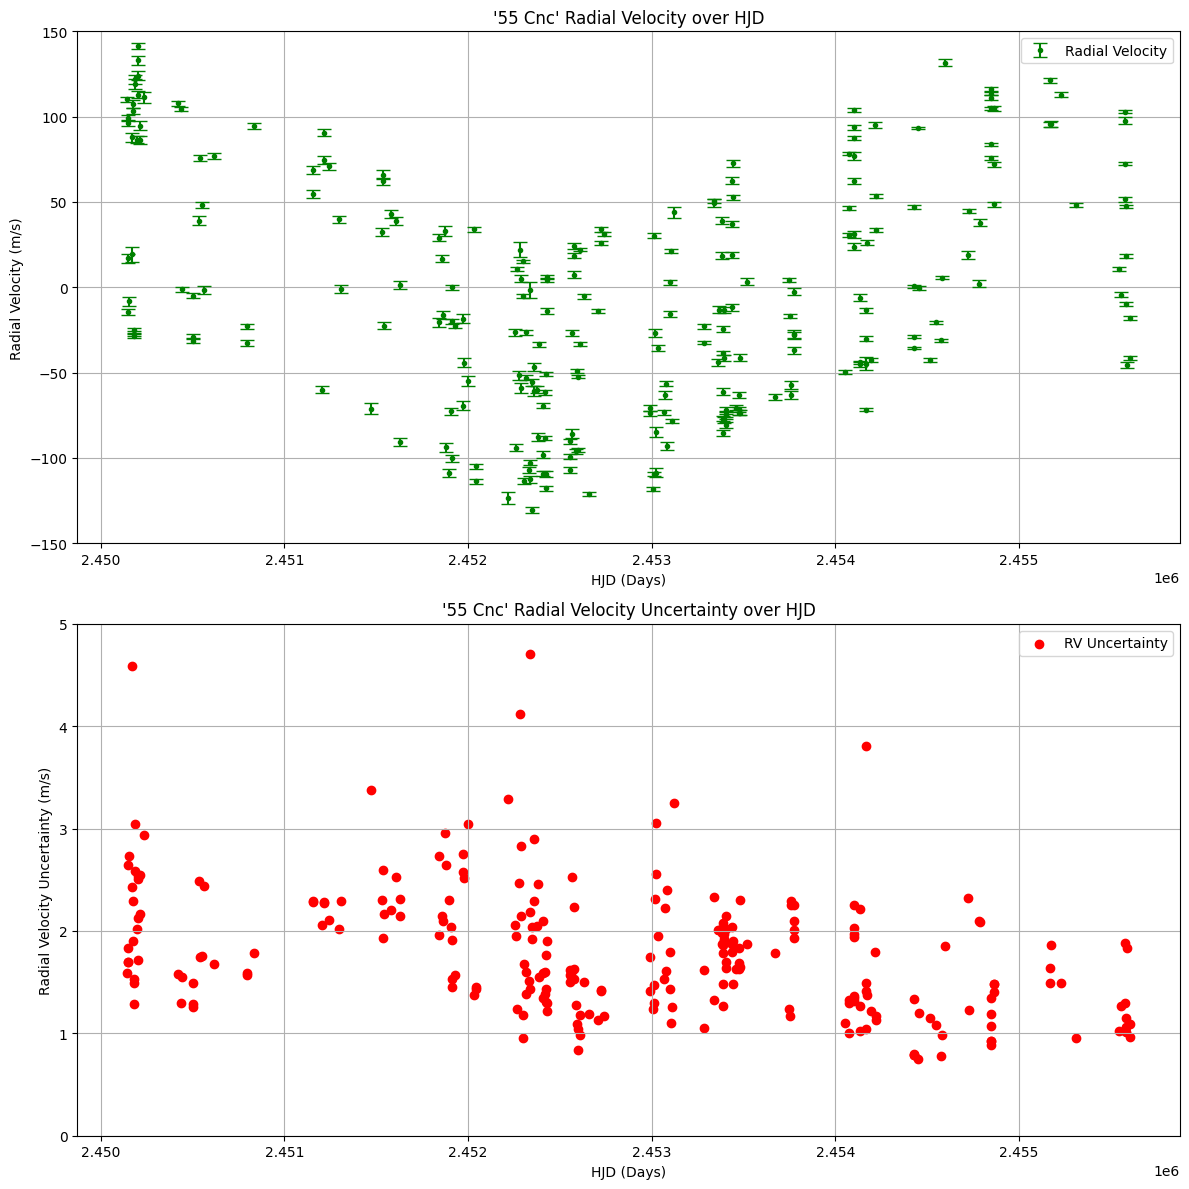

<Figure size 640x480 with 0 Axes>

In [8]:
plot_data('exoplanetinfo.txt')

In [9]:
from scipy import optimize
from scipy import interpolate
from astropy.table import Table

In [10]:
"""
global_data_unpack[0] = x or HJD (Days)
global_data_unpack[1] = y1 or rv
global_data_unpack[2] = y2 or rv_uncertainty
"""

# --Describes the basic sine function--
def f_curve(x, a, b, c, d):
    
    """
    Parameters:
        x : HJD
        a : Amplitude      
        b : Horizontal shift   
        c : Period
        d : Vertical shift
    """
    
    return a * np.sin(2.0 * np.pi*(x - b) / c) + d

# --Estimate Initial Parameters
v_shift = np.mean(global_data_unpack[1]) # Vertical shift (mean of RV)
amplitude = np.mean(np.abs(global_data_unpack[1])) + v_shift # Conservative amplitude estimate in case of many outliers
h_shift = -8*((np.max(global_data_unpack[0]) - np.min(global_data_unpack[0]))/100) # Rough phase shift guess
period = 4700 # Initial period guess

initial_guess = [amplitude, h_shift, period, v_shift]

# --Test prints--
print("Initial horizontal shift:", h_shift)
print("Initial amplitude:", amplitude)
print("Standard deviation of RV:", np.std(global_data_unpack[1]))

# --Fitting model--
params, params_cov = optimize.curve_fit(
    f_curve, global_data_unpack[0], global_data_unpack[1], 
    sigma = global_data_unpack[2], absolute_sigma = True,
                                       p0 = initial_guess)

Initial horizontal shift: -474.2192671999708
Initial amplitude: 56.55306289622202
Standard deviation of RV: 67.06616160864814


Fitted parameters: [ 4.81950110e+01 -5.73998351e+02  4.70204178e+03 -1.64882079e+00]


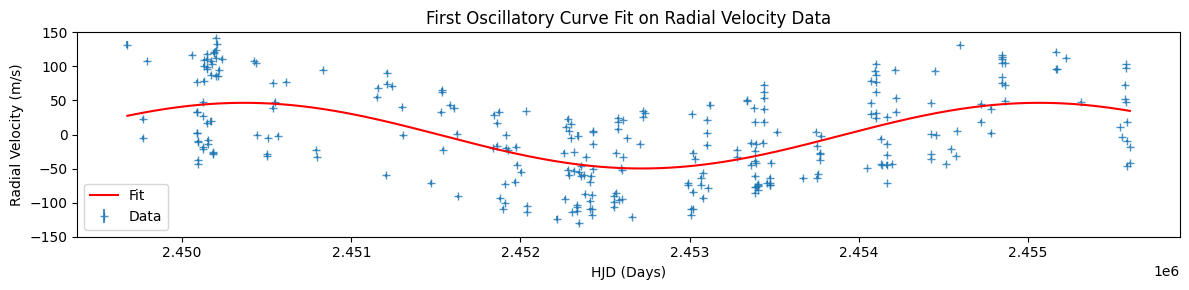

In [11]:

# --Adaptive bounds based on initial guess--

rfe = 100 # Defines room for error

low_bound = [np.ceil(initial_guess[0]) - rfe, 
             np.ceil(initial_guess[1]) - rfe, 
             np.ceil(initial_guess[2]) - rfe, 
             np.ceil(initial_guess[3]) - rfe]
    #Sets every value in the initial guess to 
    #be mapped to the ceiling of the value at the given index -1

high_bound = [np.floor(initial_guess[0]) + rfe, 
              np.floor(initial_guess[1]) + rfe, 
              np.floor(initial_guess[2]) + rfe, 
              np.floor(initial_guess[3]) + rfe]
    #Sets every value in the initial guess to 
    #be mapped to the floor of the value at the given index +1

# --Curve fitting--
params, params_cov = optimize.curve_fit(
    f_curve, global_data_unpack[0], global_data_unpack[1], 
    sigma = global_data_unpack[2], absolute_sigma = True,
                                       p0 = initial_guess, bounds = (low_bound, high_bound))

print(f"Fitted parameters: {params}")
coefficients1 = (params[0], params[1], params[2], params[3])

# --Plot best fit model along with data--
x_fit = np.linspace(np.min(global_data_unpack[0]), np.max(global_data_unpack[0]), 500)
y_fit = f_curve(x_fit, *params) # *params unpacks parameters into a,b,c,d

fig = plt.subplots(1, 1, figsize=(12,3))

plt.errorbar(global_data_unpack[0], global_data_unpack[1], 
             global_data_unpack[2], fmt='+', label = 'Data', 
             alpha=0.8, zorder = 1) # Data

plt.plot(x_fit, y_fit, 'r-', label='Fit', zorder = 2)

plt.ylabel('Radial Velocity (m/s)')
plt.xlabel('HJD (Days)')
plt.legend()
plt.title("First Oscillatory Curve Fit on Radial Velocity Data")
plt.ylim(-150, 150)
plt.yticks(np.arange(-150, 151, 50))

# --Adjust layout--
plt.tight_layout()
plt.savefig('FirstOscillatoryCurveFit.pdf')

# --Save as PDF--
plt.show()

In [12]:
# --Compute residuals (data - model)--
def residuals(x, y):
    # Returns residuals
    return y - f_curve(x, *params)

# Store the residuals
data_residuals = residuals(global_data_unpack[0], 
                           global_data_unpack[1])

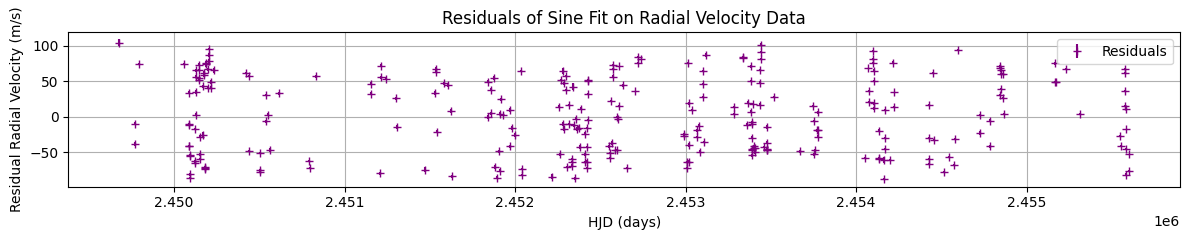

In [13]:
# --Plot residuals with error bars--

fig, ax = plt.subplots(1, 1, figsize=(12,2.5))
ax.set_xlabel('HJD (days)')
ax.set_ylabel('Residual Radial Velocity (m/s)')
ax.set_title('Residuals of Sine Fit on Radial Velocity Data')
ax.errorbar(global_data_unpack[0], data_residuals, 
            yerr=global_data_unpack[2], fmt='+',
           label='Residuals', color='purple')
plt.grid(True)
plt.tight_layout()
plt.legend()

In [14]:
# --Calculate standard deviation of the residuals--
print(np.mean(data_residuals))
print(np.std(data_residuals))

1.804872150218741
52.24551328961372


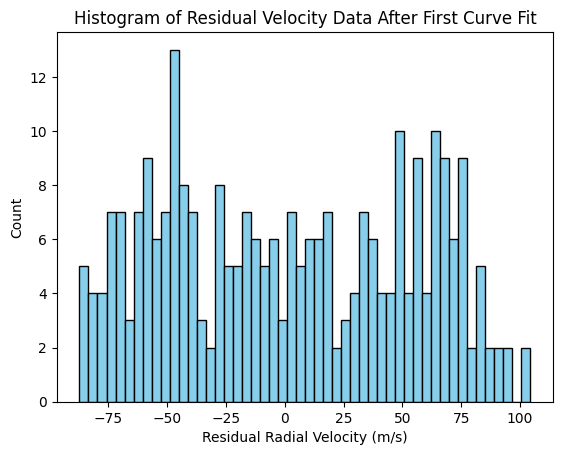

In [15]:
# --Plot histogram of the residual radial velocity--
bins = 50
plt.hist(data_residuals, bins=bins, edgecolor='black', color='skyblue')
plt.xlabel('Residual Radial Velocity (m/s)')
plt.ylabel('Count')
plt.title("Histogram of Residual Velocity Data After First Curve Fit")
plt.savefig('ResidualVelocityHistogramAfterFirstCurveFit.pdf', bbox_inches='tight', dpi=600)

In [16]:
# --Compare the scatter in the residuals with the uncertainties--
print(f"The mean of the residual radial velocity: \n{np.mean(data_residuals)}")
print(f"The standard deviation of the residual radial velocity: \n{np.std(data_residuals)}")
print()
print(f"The mean of the radial velocity uncertainty: \n{np.mean(global_data_unpack[2])}")
print(f"The standard deviation of the radial velocity uncertainty: \n{np.std(global_data_unpack[2])}")

The mean of the residual radial velocity: 
1.804872150218741
The standard deviation of the residual radial velocity: 
52.24551328961372

The mean of the radial velocity uncertainty: 
1.8060667343065693
The standard deviation of the radial velocity uncertainty: 
0.6427887768668138


In [17]:
print(f"The standard deviation of the residual radial velocity is much higher (about 10x) than the radial velocity uncertainty.")
print(f"Therefore, the data indicates another planet.")

The standard deviation of the residual radial velocity is much higher (about 10x) than the radial velocity uncertainty.
Therefore, the data indicates another planet.


In [18]:
from scipy.optimize import curve_fit

1.804872150218741
47.72045710363028
Fitted parameters: [7.00000000e+01 2.45332589e+06 1.32025595e+01 1.09619573e+00]
Fitted params error
: [1.41302658e-01 3.70365733e-03 3.09979634e-05 9.38089449e-02]


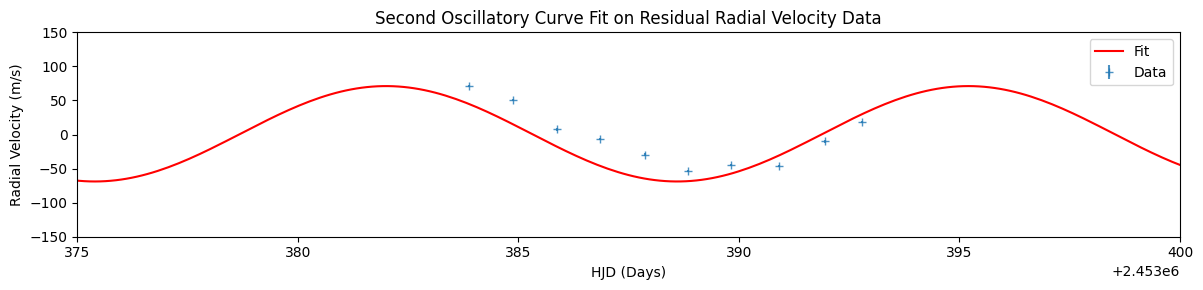

In [19]:
# --Find a second planet--

# --Estimate parameters from the residuals--
v_shift2 = np.mean(data_residuals)
amplitude2 = np.mean(np.abs(data_residuals)) + v_shift2
h_shift2 = 2.4508 * (10**6)
period2 = (2.4535-2.4512) * (10**6)

# Test prints
print(v_shift2)
print(amplitude2)

# vvv Alternative initial guess vvv
#initial_guess2 = [amplitude2, h_shift2, period2, v_shift2]
initial_guess2 = [75, 2453322, 13.209, v_shift2]

# --Bounds for curve fitting--
rfe2 = 5
low_bound2 = [np.ceil(initial_guess2[0]) - rfe2, 
              np.ceil(initial_guess2[1]) - rfe2, 
              np.ceil(initial_guess2[2]) - rfe2, 
              np.ceil(initial_guess2[3]) - rfe2]

high_bound2 = [np.floor(initial_guess2[0]) + rfe2, 
               np.floor(initial_guess2[1]) + rfe2, 
               np.floor(initial_guess2[2]) + rfe2, 
               np.floor(initial_guess2[3]) + rfe2]

# --Second sine curve fit to residuals--
params2, params_cov2 = optimize.curve_fit(f_curve, global_data_unpack[0], data_residuals, 
                                          sigma = global_data_unpack[2], absolute_sigma = True,
                                          p0 = initial_guess2, bounds = (low_bound2, high_bound2))

# Print results
print(f"Fitted parameters: {params2}")
#print(f"Fitted covariances\n: {params_cov2}")
params_err2 = np.sqrt(np.diag(params_cov2))
print(f"Fitted params error\n: {params_err2}")

coefficients2 = (params2[0], params2[1], params2[2], params2[3])

# Generate fit line
x_fit2 = np.linspace(np.min(global_data_unpack[0]), np.max(global_data_unpack[0]), 50000)
y_fit2 = f_curve(x_fit2, *params2)

# --Plot second fit on the residual radial velocity data
fig = plt.subplots(1, 1, figsize=(12,3))
plt.errorbar(global_data_unpack[0], data_residuals, global_data_unpack[2], 
             fmt='+', label = 'Data', alpha=0.8, zorder = 1)
plt.plot(x_fit2, y_fit2, 'r-', label='Fit', zorder = 2)
plt.ylabel('Radial Velocity (m/s)')
plt.xlabel('HJD (Days)')
plt.legend()
plt.title("Second Oscillatory Curve Fit on Residual Radial Velocity Data")

plt.ylim(-150, 150)
plt.yticks(np.arange(-150, 151, 50))

plt.tight_layout()
plt.xlim(2.453375e6, 2.453400e6)
plt.savefig('SecondOscillatoryCurveFit.pdf')
plt.show()

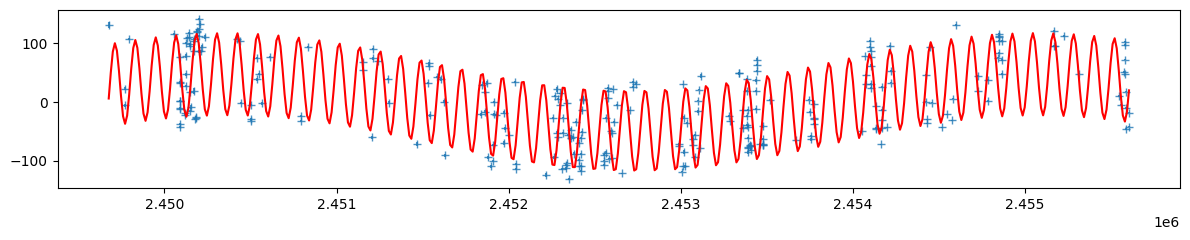

In [20]:
#let's see how the two planet fit looks by plotting it, along with the data
x_fit = np.linspace(np.min(global_data_unpack[0]), np.max(global_data_unpack[0]), 500)
y_fit = f_curve(x_fit, *coefficients1) + f_curve(x_fit, *coefficients2)

fig = plt.subplots(1, 1, figsize=(12,2.5))

plt.errorbar(global_data_unpack[0], global_data_unpack[1], global_data_unpack[2], fmt='+', label = 'Data', alpha=0.8, zorder = 1) #data
plt.plot(x_fit, y_fit, 'r-', label='Fit', zorder = 2)

plt.tight_layout()
plt.show()

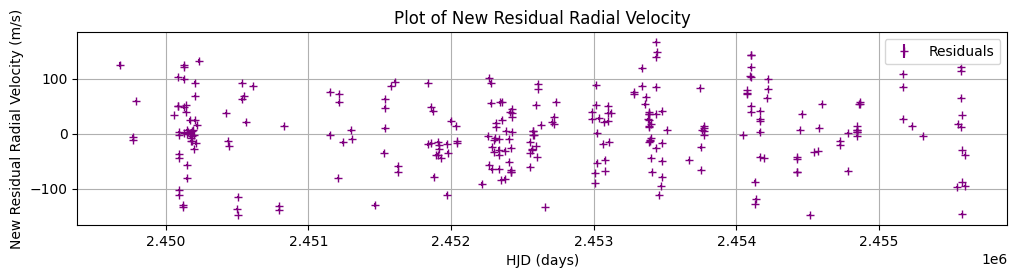

In [21]:
# --Obtain and plot new residuals--
def new_residuals(x, y):
    return y - f_curve(x, *params2)
# Store the new residuals
new_data_residuals = new_residuals(global_data_unpack[0], data_residuals)
fig, ax = plt.subplots(1, 1, figsize=(12,2.5))
ax.set_xlabel('HJD (days)')
ax.set_ylabel('New Residual Radial Velocity (m/s)')
ax.errorbar(global_data_unpack[0], new_data_residuals, 
            yerr=global_data_unpack[2], fmt='+',
           label='Residuals', color='purple')
ax.set_title('Plot of New Residual Radial Velocity')
plt.grid(True)
plt.legend()

4.493807255198372
63.36781758601508


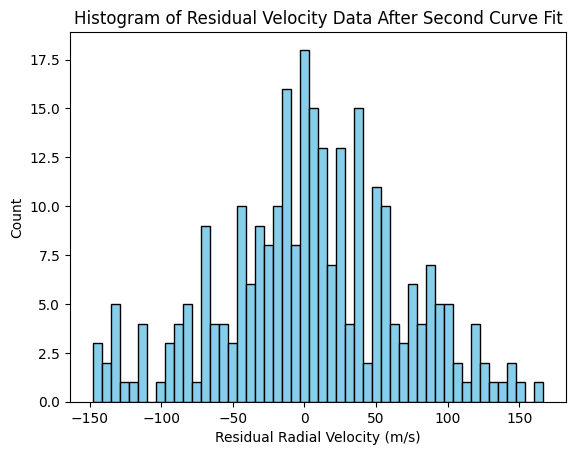

In [22]:
# --Determine the standard deviation of the residuals and plot histogram--
print(np.mean(new_data_residuals))
print(np.std(new_data_residuals))

bins = 50
plt.hist(new_data_residuals, bins=bins, edgecolor='black', color='skyblue')
plt.xlabel('Residual Radial Velocity (m/s)')
plt.ylabel('Count')
plt.title("Histogram of Residual Velocity Data After Second Curve Fit")
plt.savefig('ResidualVelocityHistogramAfterSecondCurveFit.pdf', bbox_inches='tight', dpi=600)

Fitted parameters: [1.27727159e+01 2.45000495e+06 4.48506561e+01 1.50005703e+01]
Fitted params error
: [0.13573606 0.16311686 0.00210647 0.09357438]


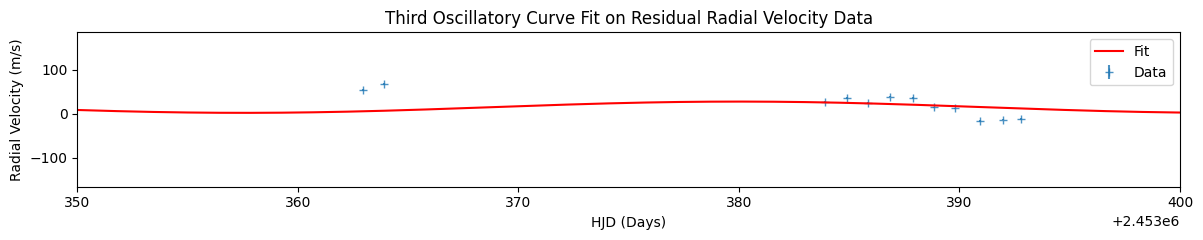

In [23]:
# --Find a third planet--
v_shift3 = np.mean(new_data_residuals)
#amplitude2 = np.mean(np.abs(data_residuals)) + v_shift2
#h_shift2 = 2.4508 * (10**6)
#period2 = (2.4535-2.4512) * (10**6)
#initial_guess2 = [amplitude2, h_shift2, period2, v_shift2]
initial_guess3 = [10.5, 2.450e6, 45, 20]
#initial_guess3 = [65, 2.4558e6, 9.5, v_shift3]
#print(v_shift3)


# Range for each parameter around guess
rfe3 = 5
low_bound3 = [np.ceil(initial_guess3[0]) - rfe3, 
              np.ceil(initial_guess3[1]) - rfe3, 
              np.ceil(initial_guess3[2]) - rfe3, 
              np.ceil(initial_guess3[3]) - rfe3]

high_bound3 = [np.floor(initial_guess3[0]) + rfe3, 
               np.floor(initial_guess3[1]) + rfe3, 
               np.floor(initial_guess3[2]) + rfe3, 
               np.floor(initial_guess3[3]) + rfe3]

# Fit sine curve to residuals
params3, params_cov3 = optimize.curve_fit(f_curve, global_data_unpack[0], new_data_residuals, 
                                          sigma = global_data_unpack[2], absolute_sigma = True,
                                          p0 = initial_guess3, bounds = (low_bound3, high_bound3))

# Print parameter results
print(f"Fitted parameters: {params3}")
#print(f"Fitted covariances\n: {params_cov3}")
params_err3 = np.sqrt(np.diag(params_cov3))
print(f"Fitted params error\n: {params_err3}")

coefficients3 = (params3[0], params3[1], params3[2], params3[3])

# Generate fit line
x_fit3 = np.linspace(np.min(global_data_unpack[0]), np.max(global_data_unpack[0]), 50000)
y_fit3 = f_curve(x_fit3, *params3)

# --Plot third fit on the residual radial velocity data--
fig = plt.subplots(1, 1, figsize=(12,2.5))

plt.errorbar(global_data_unpack[0], new_data_residuals, global_data_unpack[2], fmt='+', label = 'Data', alpha=0.8, zorder = 1)
plt.plot(x_fit3, y_fit3, 'r-', label='Fit', zorder = 2)

plt.ylabel('Radial Velocity (m/s)')
plt.xlabel('HJD (Days)')
plt.legend()
plt.title("Third Oscillatory Curve Fit on Residual Radial Velocity Data")

plt.tight_layout()
plt.xlim(2.453350e6, 2.453400e6)

# initial_guess3 = [40, 2.450e6, 20, 20] &
# plt.xlim(2.453350e6, 2.453400e6)

# For new amplitude and period
#plt.xlim(2.45015e6, 2.45025e6)

# For old amplitude and period
#plt.xlim(2.45010e6, 2.45015e6)
#plt.xlim(2.45005e6, 2.45010e6)
#plt.xlim(2.45346e6, 2.45349e6)

plt.savefig('ThirdOscillatoryCurveFit.pdf')
plt.show()

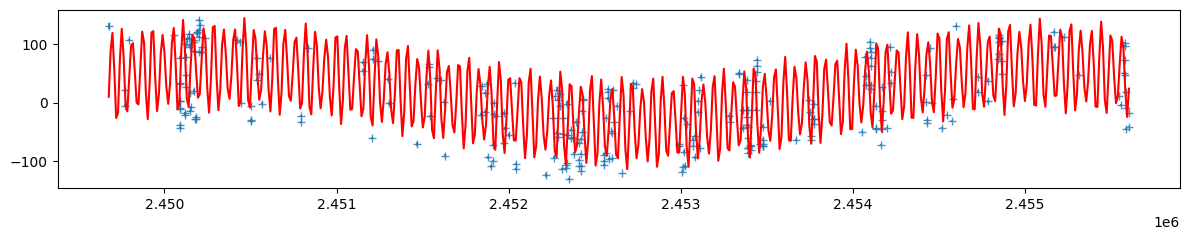

In [24]:
#let's see how the three planet fit looks by plotting it, along with the data
x_fit = np.linspace(np.min(global_data_unpack[0]), np.max(global_data_unpack[0]), 550)
y_fit = f_curve(x_fit, *coefficients1) + f_curve(x_fit, *coefficients2) + f_curve(x_fit, *coefficients3)

fig = plt.subplots(1, 1, figsize=(12,2.5))

plt.errorbar(global_data_unpack[0], global_data_unpack[1], global_data_unpack[2], fmt='+', label = 'Data', alpha=0.8, zorder = 1) #data
plt.plot(x_fit, y_fit, 'r-', label='Fit', zorder = 2)

#plt.xlim(2.452e6, 2.4525e6)
plt.tight_layout()
plt.show()

In [25]:
def calculate_exoplanet_mass(K, P, Ms):
    return (K / 28.4) * ((P / 365)**(1/3)) * ((Ms)**(2/3))
    
A1 = coefficients1[0]
P1 = coefficients1[2]

A2 = coefficients2[0]
P2 = coefficients2[2]

A3 = coefficients3[0]
P3 = coefficients3[2]

Mcnc = 0.905 # Mass of 55 CNC A (main star of the system)
mass1 = calculate_exoplanet_mass(np.abs(A1), P1, Mcnc)
mass2 = calculate_exoplanet_mass(np.abs(A2), P2, Mcnc)
mass3 = calculate_exoplanet_mass(np.abs(A3), P3, Mcnc)

print("Planet 1:")
print(f"\tAmplitude = {A1:.2f} m/s")
print(f"\tPeriod = {P1:.2f} days")
print(f"\tMass = {mass1:.3f} Jupiter mass")

print("Planet 2:")
print(f"\tAmplitude = {A2:.2f} m/s")
print(f"\tPeriod = {P2:.2f} days")
print(f"\tMass = {mass2:.3f} Jupiter mass")

print("Planet 3:")
print(f"\tAmplitude = {A3:.2f} m/s")
print(f"\tPeriod = {P3:.2f} days")
print(f"\tMass = {mass3:.3f} Jupiter mass")

# Check if the calculated period lies within 20% of the 
# known period to identify the planet
def identify_planet(P):
    if abs(P - 0.7365) < (0.2 * 0.74):
        return "Could be 55 Cancri e"
    elif abs(P - 14.65) < (0.2 * 14.65):
        return "Could be 55 Cancri b"
    elif abs(P - 44.40) < (0.2 * 44.40):
        return "Could be 55 Cancri c"
    elif abs(P - 260.0) < (0.2 * 260.0):
        return "Could be 55 Cancri f"
    elif abs(P - 5574) < (0.2 * 5574):
        return "Could be 55 Cancri d" 
    else:
        return "Unknown Cancri planet"

print(f"Planet 1: {identify_planet(P1)}")
print(f"Planet 2: {identify_planet(P2)}")
print(f"Planet 3: {identify_planet(P3)}")

Planet 1:
	Amplitude = 48.20 m/s
	Period = 4702.04 days
	Mass = 3.722 Jupiter mass
Planet 2:
	Amplitude = 70.00 m/s
	Period = 13.20 days
	Mass = 0.763 Jupiter mass
Planet 3:
	Amplitude = 12.77 m/s
	Period = 44.85 days
	Mass = 0.209 Jupiter mass
Planet 1: Could be 55 Cancri d
Planet 2: Could be 55 Cancri b
Planet 3: Could be 55 Cancri c


In [26]:
# Assume x = time (HJD), y = radial velocity, y_err = uncertainty
def plot_data(text_file):
    # set variables
    data_arrays = read_data_from_txt(text_file)
    hjd = data_arrays[0]
    rv = data_arrays[1]
    rv_uncertainty = data_arrays[2]
    # initialize figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5)) #sharey=True

hjd, rv, rv_uncertainty = read_data_from_txt('exoplanetinfo.txt')

# --Define two-planet model--
def two_planet_model(t, A1, phi1, P1, A2, phi2, P2, offset):
    term1 = A1 * np.sin(2 * np.pi * (t - phi1) / P1)
    term2 = A2 * np.sin(2 * np.pi * (t - phi2) / P2)
    return term1 + term2 + offset

# From Step 4
initial_guess = [
    55.43, 24500.0, 67.07,   # Planet 1
    30.0, 2460000.0, 44.3,   # Planet 2 (rough estimate)
    0.0                     # Offset
]

# --Fit the model to the data--
params, covariance = curve_fit(
    two_planet_model, hjd, rv, sigma=rv_uncertainty,
    absolute_sigma=True, p0=initial_guess, maxfev=20000
)

# Unpack results
A1, phi1, P1, A2, phi2, P2, offset = params
print(f"Planet 1: Amplitude = {A1:.2f} m/s, Period = {P1:.2f} days")
print(f"Planet 2: Amplitude = {A2:.2f} m/s, Period = {P2:.2f} days")

Planet 1: Amplitude = -26.92 m/s, Period = 67.10 days
Planet 2: Amplitude = -20.48 m/s, Period = 44.69 days


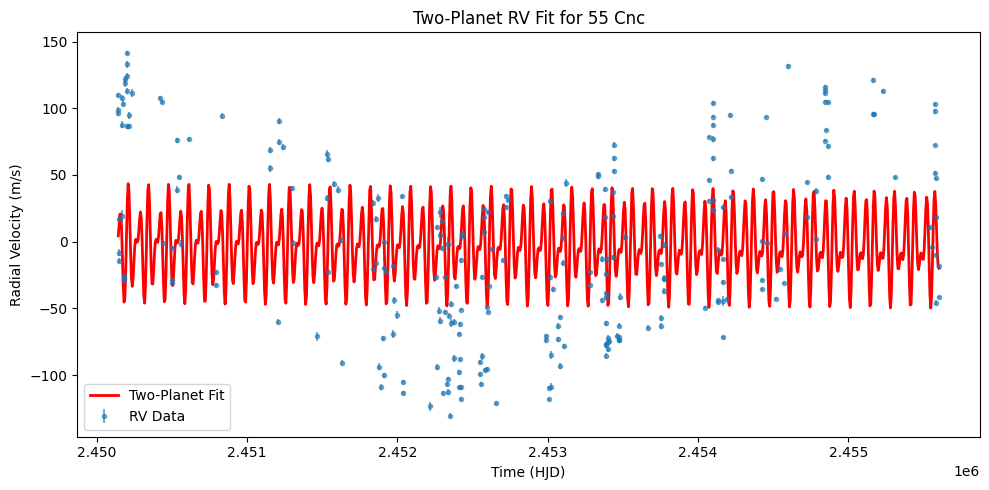

In [27]:
# --Plot fit--
x_fit = np.linspace(np.min(hjd), np.max(hjd), 1000)
y_fit = two_planet_model(x_fit, *params)

plt.figure(figsize=(10, 5))
plt.errorbar(hjd, rv, yerr=rv_uncertainty, fmt='o', markersize=3, label='RV Data', alpha=0.6)
plt.plot(x_fit, y_fit, 'r-', label='Two-Planet Fit', linewidth=2)
plt.xlabel("Time (HJD)")
plt.ylabel("Radial Velocity (m/s)")
plt.title("Two-Planet RV Fit for 55 Cnc")
plt.legend()
plt.tight_layout()
plt.savefig("55Cnc_TwoPlanetFit.pdf")
plt.show()

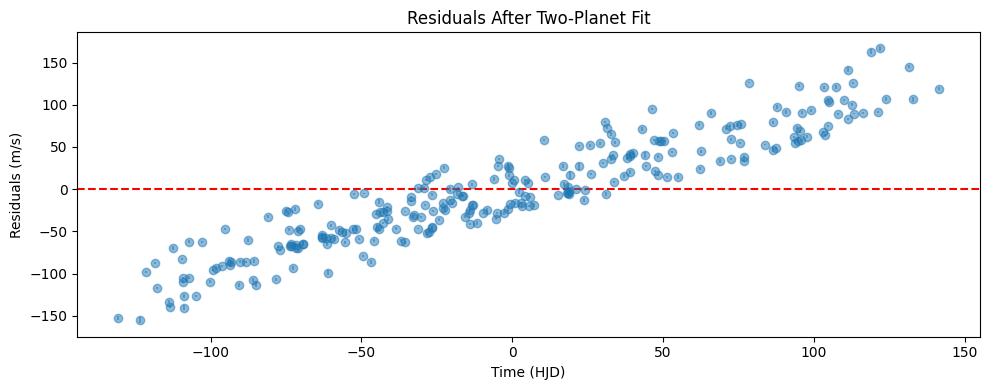

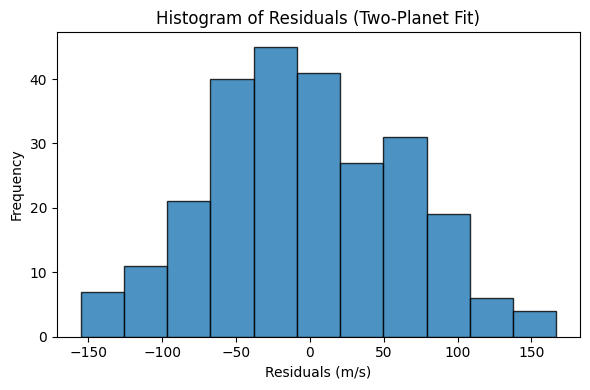

Standard deviation of residuals: 65.05405803338569
Mean measurement uncertainty: 1.7877868476190477


In [28]:
# --Residuals--
residuals = rv - two_planet_model(hjd, *params)

plt.figure(figsize=(10, 4))
plt.errorbar(rv, residuals, yerr=rv_uncertainty, fmt='o', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time (HJD)")
plt.ylabel("Residuals (m/s)")
plt.title("Residuals After Two-Planet Fit")
plt.tight_layout()
plt.savefig("55Cnc_TwoPlanetResiduals.pdf")
plt.show()

# Histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins='auto', edgecolor='black', alpha=0.8)
plt.xlabel("Residuals (m/s)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (Two-Planet Fit)")
plt.tight_layout()
plt.savefig("55Cnc_TwoPlanet_Histogram.pdf")
plt.show()

# Std deviation comparison
print("Standard deviation of residuals:", np.std(residuals))
print("Mean measurement uncertainty:", np.mean(rv_uncertainty))

In [29]:
def estimate_planet_mass_old(K, P, M_star=0.905):
    """
    Estimate the minimum planet mass (M_p sin(i)) in Jupiter masses.
    K: RV semi-amplitude in m/s
    P: Orbital period in days
    M_star: Stellar mass in solar masses (default 55 Cnc = 0.905)
    """
    return (np.abs(K) * (P ** (1/3)) * (M_star ** (2/3))) / 28.4329

# Calculate masses using absolute value of amplitude
mass1 = estimate_planet_mass_old(np.abs(A1), P1)
mass2 = estimate_planet_mass_old(np.abs(A2), P2)

# Print full results
print("Planet 1:")
print(f"  Period = {P1:.2f} days")
print(f"  Amplitude = {A1:.2f} m/s")
print(f"  Estimated Mass = {mass1:.3f} M_Jup")

print("Planet 2:")
print(f"  Period = {P2:.2f} days")
print(f"  Amplitude = {A2:.2f} m/s")
print(f"  Estimated Mass = {mass2:.3f} M_Jup")

# Basic interpretation
def match_known_planet(P):
    if abs(P - 14.65) < 1:
        return "Likely 55 Cnc b (Hot Jupiter)"
    elif abs(P - 44.4) < 2:
        return "Likely 55 Cnc c (Neptune-like)"
    elif abs(P - 0.74) < 0.1:
        return "Possibly 55 Cnc e (Super-Earth)"
    elif abs(P - 260) < 10:
        return "Possibly 55 Cnc f (outer planet)"
    elif abs(P - 5170) < 100:
        return "Possibly 55 Cnc d (very distant Jupiter)" 
    else:
        return "Unknown — might be a third planet or fit artifact"

print("Interpretation:")
print(f"Planet 1: {match_known_planet(P1)}")
print(f"Planet 2: {match_known_planet(P2)}")


Planet 1:
  Period = 67.10 days
  Amplitude = -26.92 m/s
  Estimated Mass = 3.600 M_Jup
Planet 2:
  Period = 44.69 days
  Amplitude = -20.48 m/s
  Estimated Mass = 2.391 M_Jup
Interpretation:
Planet 1: Unknown — might be a third planet or fit artifact
Planet 2: Likely 55 Cnc c (Neptune-like)
